In [6]:
!pip install nltk
!pip install textblob
!pip install emoji -q
!pip install transformers datasets -q
!pip install -q tensorflow

In [36]:
import re
import string
import nltk
import kagglehub
import pandas as pd
import emoji
from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from huggingface_hub import notebook_login

In [23]:
# Download the dataset
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')
print('Data source import complete.')

# Load the CSV file
df = pd.read_csv("/kaggle/input/training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)
df.head()

Data source import complete.


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [24]:
# Rename columns
df.columns = ["sentiment", "ids", "date", "flag", "user", "text"]

# Drop unnecessary columns
df.drop(["ids", "date", "flag", "user"], axis=1, inplace=True)

# Convert sentiment labels (0 = negative, 4 = positive) to binary (0 = negative, 1 = positive)
df['sentiment'] = df['sentiment'].replace(4, 1)

# Check sentiment distribution
df.sentiment.value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

In [25]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [26]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [27]:
df['text'] = df['text'].apply(preprocess_text)

In [28]:
df.head()

,sentiment,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


In [12]:
def handle_emojis(text, mode='remove'):
    if mode == 'remove':
        return emoji.replace_emoji(text, '')
    elif mode == 'description':
        return emoji.demojize(text, language='ar')
    return text

In [13]:
df['text']=df['text'].apply(lambda x: handle_emojis(x, mode='description'))

In [14]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# Assuming X_train, X_test, y_train, y_test are needed for tokenization
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_ckpt)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [31]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [32]:
# Convert encodings to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

I0000 00:00:1746837188.343268      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746837188.344007      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics_fn(pred):
    labels = pred.label_ids  # Ground truth
    preds = pred.predictions.argmax(-1)  # Predicted labels
    f1 = f1_score(labels, preds, average='weighted')  # Weighted F1 for multiclass
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [37]:
# Login using Key Token from HuggingFace (to be write permission)
notebook_login()

In [38]:
from transformers import TrainingArguments

batch_size = 32
logging_steps = len(X_train) // batch_size
my_model_chkpt = f'{model_ckpt}-finetuned-sentiment'

training_args = TrainingArguments(
    output_dir=my_model_chkpt,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',  # Save checkpoint at the end of each epoch
    save_steps=None,  # Ensure checkpoints are epoch-based, not step-based
    load_best_model_at_end=True,  # Load the best model based on metric
    metric_for_best_model='f1',  # Use F1 score to determine best model
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='info',
    report_to=["none"]
)

In [39]:
from transformers import Trainer

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Tokenize validation set
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

# Convert pandas DataFrame to Dataset for Trainer
from datasets import Dataset

train_dataset_hf = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
val_dataset_hf = Dataset.from_pandas(pd.DataFrame({'text': X_val, 'label': y_val}))

# Tokenize datasets
def tokenize_fn(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128, return_tensors='pt')

train_dataset_hf = train_dataset_hf.map(tokenize_fn, batched=True)
val_dataset_hf = val_dataset_hf.map(tokenize_fn, batched=True)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics_fn,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    tokenizer=tokenizer
)

# Start training
trainer.train()

Map:   0%|          | 0/1024000 [00:00<?, ? examples/s]

Map:   0%|          | 0/256000 [00:00<?, ? examples/s]

/tmp/ipykernel_31/2764971505.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text, __index_level_0__. If token_type_ids, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1,024,000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Training with DataParallel so batch size has been adjusted to: 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 32,000
  Number of trainable parameters = 66,955,010
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.338201,0.852379,0.852374
2,No log,0.334948,0.854977,0.854955


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text, __index_level_0__. If token_type_ids, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 256000
  Batch size = 64
Saving model checkpoint to distilbert-base-uncased-finetuned-sentiment/checkpoint-16000
Configuration saved in distilbert-base-uncased-finetuned-sentiment/checkpoint-16000/config.json
Model weights saved in distilbert-base-uncased-finetuned-sentiment/checkpoint-16000/model.safetensors
tokenizer config file saved in distilbert-base-uncased-finetuned-sentiment/checkpoint-16000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-sentiment/checkpoint-16000/special_tokens_map.json
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:

TrainOutput(global_step=32000, training_loss=0.33741519165039063, metrics={'train_runtime': 8061.3784, 'train_samples_per_second': 254.051, 'train_steps_per_second': 3.97, 'total_flos': 3.167997579077837e+16, 'train_loss': 0.33741519165039063, 'epoch': 2.0})

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text, __index_level_0__. If token_type_ids, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 256000
  Batch size = 64
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


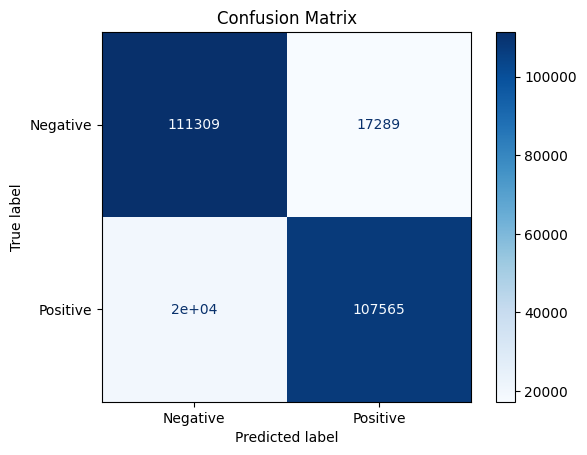

In [40]:
# Evaluate on validation set
preds_output_valid = trainer.predict(val_dataset_hf)
y_preds_valid = np.argmax(preds_output_valid.predictions, axis=1)

# Compute metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix_fn(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_conf_matrix_fn(y_preds=y_preds_valid, y_true=y_val)

Map:   0%|          | 0/320000 [00:00<?, ? examples/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text, __index_level_0__. If token_type_ids, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 320000
  Batch size = 64
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


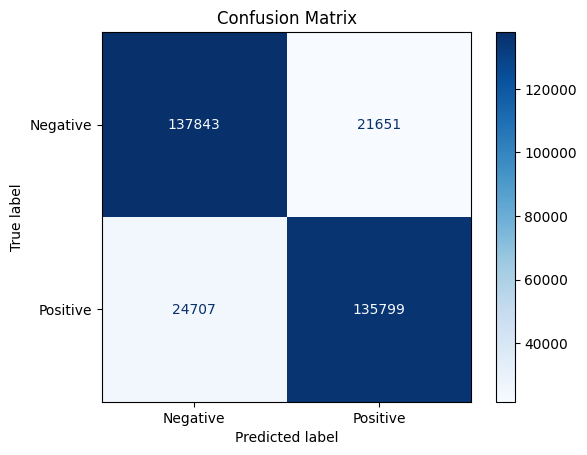

In [41]:
# Tokenize and predict on test set
test_dataset_hf = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))
test_dataset_hf = test_dataset_hf.map(tokenize_fn, batched=True)
preds_output_test = trainer.predict(test_dataset_hf)
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

# Plot confusion matrix for test set
plot_conf_matrix_fn(y_preds=y_preds_test, y_true=y_test)

In [42]:
# Login using Key Token from HuggingFace (to be write permission)
notebook_login()

In [44]:
# Define a save path
model_save_path = "/kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic"

# Save the model and tokenizer
trainer.model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


Configuration saved in /kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/config.json
Model weights saved in /kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/model.safetensors
tokenizer config file saved in /kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/tokenizer_config.json
Special tokens file saved in /kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/special_tokens_map.json


('/kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/tokenizer_config.json',
 '/kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/special_tokens_map.json',
 '/kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/vocab.txt',
 '/kaggle/working/distilbert-base-uncased-finetuned-sentiment/semantic/added_tokens.json')

In [54]:
from huggingface_hub import HfApi, create_repo
import os

# 1. Login first
from huggingface_hub import notebook_login
notebook_login()

# 2. Create repository
repo_id = "mahmoudelbahy33/distilbert-base-uncased-finetuned-sentiment"
create_repo(repo_id, exist_ok=True)

# 3. Upload all files
api = HfApi()
api.upload_folder(
    folder_path="distilbert-base-uncased-finetuned-sentiment",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model successfully uploaded to: https://huggingface.co/{repo_id}")

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 13 LFS files:   0%|          | 0/13 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Model successfully uploaded to: https://huggingface.co/mahmoudelbahy33/distilbert-base-uncased-finetuned-sentiment
